# Linear Regression | Gradient Decent

## Problem Description

For this homework problem, you are going to fit a linear regression model to some simulated data (Homework_3_train_set.csv and Homework_3_test_set.csv), which is illustrated in the figure below, using the following libraries only: Numpy * (for linear algebra), Matplotlib (for plotting) and Pandas (for loading the .CSV file containing the datasets). All the information you need to complete this homework problem may be found in Benjamin Rosman's lecture titled "Linear Regression" which you can find on Slack.

In [ ]:
***Important Note:** we want you to code your linear regression model from first principles (i.e. we want you to code the gradient descent algoirthm directly from the equations). So it is OK to use Numpy functions like [Numpy.dot()](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) (for taking dot products), [Numpy.random.uniform()](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) (for generating random numbers from a uniform ditribution), [Numpy.zeros()](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html) (for generating a matrix of arbitrary dimensions filled with 0s) -- any functions like that are OK to use. However, we don't want you to use [Numpy.polyfit()](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), which automatically fits a polynomial function to your data using linear regression, or anything that fits a model automatically for you, as this defeats the whole purpose of the exercise. If you are unsure whether or not a function is OK to use, please ask! :) Ref: https://www.kaggle.com/code/matthewmaddock/linear-regression-gradient-decent-begin 

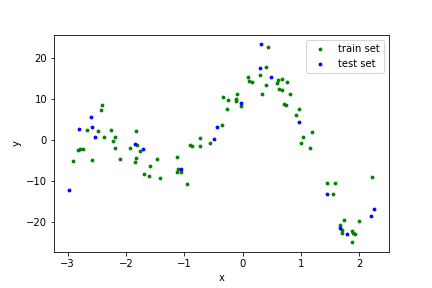

Please submit your solution in a Google colab notebook. You may make a new notebook or copy this notebook to your own Google Drive (by clicking file > Save copy in Drive from the menu above) and edit it from there. You are free to layout your Google Colab notebook in any way you choose, but, at a minimum, we would like you to:

    Include headings above all your sections, and coherent explainations written out for all your steps (we won't give any marks if you write code with no explainations)
    Visualise the data
    Prepare a design matrix (see the hint below)
    Fit a linear regression model using the closed form solution
    Fit a linear regression model using the gradient descent algorithm and include the following in the report:
        Details about the loss/cost function you chose and why
        Details about the learing rate you used and why
        Details about the regularisation method you chose (if any) and why (or why not)
        Plot the learning curve(s) of your gradient descent algoirthm (i.e. the value of the objective function after each parameter update) - can you see that the model has converged?
    Include the following once your linear regression model is fitted:
        The final values of the model parameters as determined by your gradient descent algoirthm
        The mean squared error (MSE) between (i) your model predictions and labels belonging to the train dataset, and (ii) your model predictions and the labels belonging to the test dataset
        A Visualisation of your fitted model over the data

When you fit your model over the data, it should look something like this:

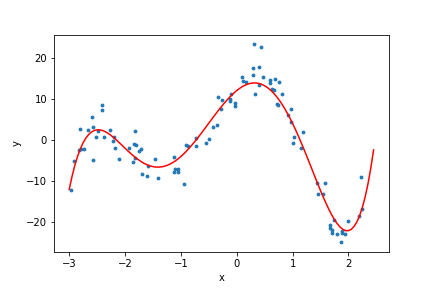

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
LRGD_train_data = pd.read_csv('../data/Train_data.csv')
LGRD_test_data = pd.read_csv('../data/test_data.csv')

In [3]:
LRGD_train_data.head()

,Unnamed: 0,X_train,Y_train
0,0,-2.420673,7.325422
1,1,1.708804,-22.546261
2,2,1.995098,-19.572188
3,3,0.602369,14.626156
4,4,-1.851973,-5.255295


In [4]:
LGRD_test_data.head()

,Unnamed: 0,X_test,Y_test
0,0,-1.840398,-1.056061
1,1,-2.972049,-12.205413
2,2,-2.806753,2.611475
3,3,2.195085,-18.339535
4,4,-0.431786,3.085342


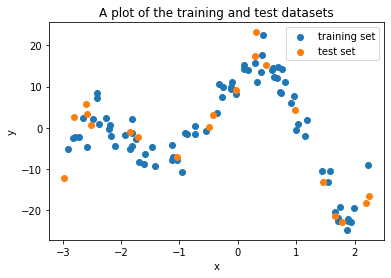

In [5]:
plt.scatter(LRGD_train_data["X_train"].values, LRGD_train_data["Y_train"].values, label="training set")
plt.scatter(LGRD_test_data["X_test"].values, LGRD_test_data["Y_test"].values, label="test set")
plt.xlabel("x")
plt.ylabel("y")
plt.title("A plot of the training and test datasets")
plt.legend()
plt.show()

#### Creating design matrix: adding polynomial features

As you can probably see from the plot above, the polynomial function is at least an order 5 polynomial (because it has 4 turning points). Let's create a function to return a design matrix to us with polynomial features up to a given degree.

Remeber, a polynomial of degree k

has the following form:
y=θ0+θ1x+⋯+θpxk

Note: remeber we will need the first column of the design matrix to contain only 1's because this will be the column corresponding to our constant parameter (θ0
) in the regression model.

In [6]:
"""
  X: a 1-D Numpy array of N data points 
  degree: the degree of the largest polynomial feature
  
  Return
  ------
  An Numpy array (matrix) with shape (N, k + 1), where each column is an ith 
  power of the vector X for i=0,...,k
  """

def poly_features(X, degree):
     return np.array([np.power(X,j) for j in range(degree + 1)]).T
# design matrix with polynomial features
poly_degree = 5
X_train = poly_features(LRGD_train_data['X_train'].values, degree=poly_degree)
y_train = LRGD_train_data['Y_train'].values

print(f"X shape: {X_train.shape}, y shape: {y_train.shape}")
print("First sample of training data:", X_train[0]) # [1, x, x^2, ..., x^k]

X shape: (80, 6), y shape: (80,)
First sample of training data: [  1.          -2.4206733    5.85965923 -14.18432064  34.33560626
 -83.11528532]


#### Normalising the data (necessary for gradient descent)
You will often find when fitting a machine learning model to data that you will need to scale your training and test datasets beforehand. The reason this is necessary is because often the different features in your training dataset have very different scales; in our case, because we have created a number of polynomial features from our original training data, the higher order features (e.g. x6) will contain data points which are far larger that the lower order features (e.g. x2
). This can cause a number of problems, depending on the training algorithm you're using:

    * If you are using gradient descent to train your model, using features which have different scales can prevent the algoirthm from converging, often because the elements of your gradient vector are too large which can actually cause divergence (i.e. make your model worse) instead of convergence.
    * Unstable numerical computations on the hardware of your computer: there is a limit to the maximum or minimum value of a number which your computer can hold. Often when we are working with numerical optimisaion algoirthms, the numbers can grow too large or too small which can cause all sorts of unexpected errors, even though your algorithm may be perfect in theory.

For this reason, it is necessary for us to normalise our training data. Recall that our training data is in a design matrix with shape (N,k+1)
(where N is the number of data points, and k+1 is the number of features, which includes 1

, the first column containing all 1s) of the form:
X=[1,x1,x2,…,xk]

First, let's plot the distributions of the data points belonging to each of the features in our matrix to see how they differ.

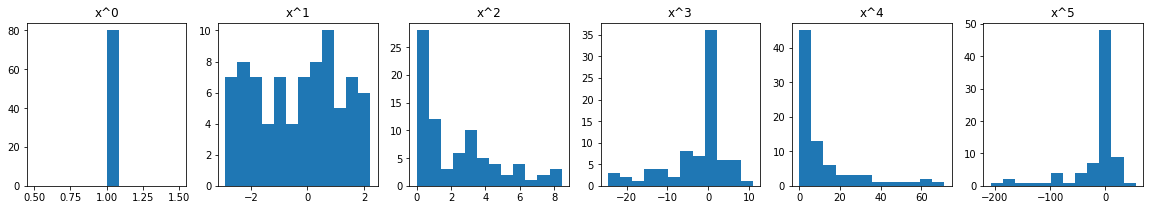

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=X_train.shape[1], figsize=(20,3))
for i in range(X_train.shape[1]):
    ax[i].hist(X_train[:,i], bins=12)
    ax[i].set_title(f"x^{i}")

plt.show()

As you can see, the feature which is just x has data in the range approximately (-2, 2), whereas the x5 feature has data in the range approximately (-200, 20). In order to fix this, we are going to using a method called z-score standardisation/normalisation (Google it to find out more) to normalise each feature. For i=1,…,k

(note how we don't normalise the feature data in the first column as every data point is just a 1), do:
xi=(xi−mean(xii))std(xi)

where std() computes the standard deviation. Transforming the data in this way has two effects:

    It centers the data at 0 (by subtracting the mean from each data point), and;
    It decreases the dispersion of the data points if the standard deviation is >1 and increases the dispersion of the data points if the standard deviation is <1

The ultimate effect is to transform the emprical distribution of the data into something representing the standard normal distribution (aka the normal distribution with a mean of 0 and a standard devation of 1).

Let's implement this and take a look at the effect it has on the distributions of our features:

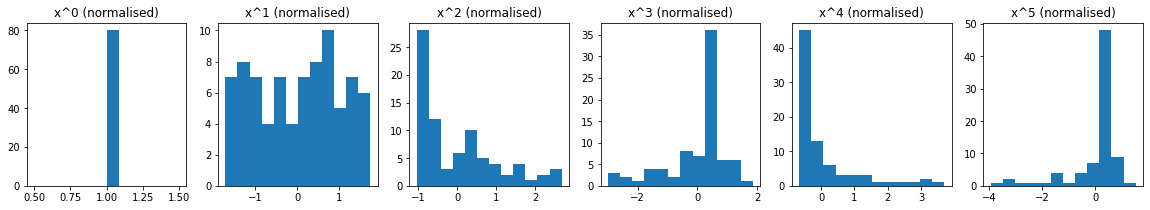

In [8]:
# Normalize feature
class FeatureNormaliser:
    """
    A simple class for performing feature noramlisation using
    the Z-standardisation method.
    """
    def fit(self, X):
        self.feature_means = np.mean(X, axis=0)
        self.feature_stds = np.std(X, axis=0)

    def transform(self, X):
        # Subtract the mean from each data point in the vector, and divide by the 
        # standard deviation 
        return (X.copy() - self.feature_means) / self.feature_stds

feature_normaliser = FeatureNormaliser()
feature_normaliser.fit(X_train[:,1:]) # NB! Don't normalise the 1st column 
X_train[:,1:] = feature_normaliser.transform(X_train[:,1:])

fig, ax = plt.subplots(nrows=1, ncols=X_train.shape[1], figsize=(20,3))

for i in range(X_train.shape[1]):
    ax[i].hist(X_train[:,i], bins=12)
    ax[i].set_title(f"x^{i} (normalised)")

plt.show()



OK, great. Now our features are all roughly in the range (-2,2) which will make it far easier for us to use gradient descent to train our linear regression model on this data.

Important Note: because you will train your linear regression model on data which has been normalised, you will need to normalise any input data you want to make a prediciton on in the future as a pre-processing step. For example, we will want to make a prediction for the data in our test set once our model has been fitted to the training data. We can use the transform() function of our FeatureNormaliser object to transform the test data using the same mean and standard deviation values we computed for the features in our traning data, as follows:


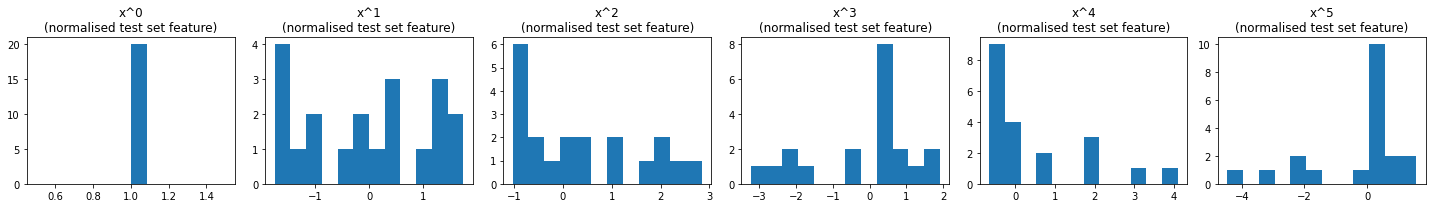

In [9]:
# first we make the polynomial features
X_test = poly_features(LGRD_test_data['X_test'].values, degree=poly_degree) 

# Then, we normalise the features using the transform() method
# Remeber: don't try normalise the first column
X_test[:,1:] = feature_normaliser.transform(X_test[:,1:]) 

fig, ax = plt.subplots(nrows=1, ncols=X_test.shape[1], figsize=(20,3))
for i in range(X_test.shape[1]):
    ax[i].hist(X_test[:,i], bins=12)
    ax[i].set_title(f"x^{i}\n(normalised test set feature)")

plt.tight_layout()
plt.show()

#### Visualise the data

This has been done above but I will repeat this for completeness. The data is of the for {x(i),y(i)}
where x(i),y(i)∈R. Therefore this data is simple to represent in a 2D plot. This is given below

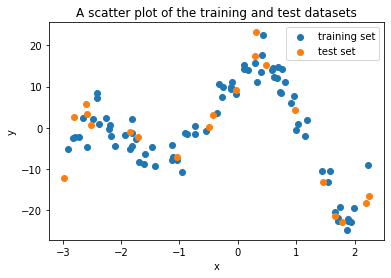

In [10]:
# Plotting the training and test set using scatterplot

plt.scatter(LRGD_train_data["X_train"].values, LRGD_train_data["Y_train"].values, label="training set")
plt.scatter(LGRD_test_data["X_test"].values, LGRD_test_data["Y_test"].values, label="test set")

# Axis labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("A scatter plot of the training and test datasets")
plt.legend()
plt.show()

#### The Design Matrix

Lets consider a 9th order polynomial (I have written the code and considered the case of a 5th order polynomial but ), I will do this so that I can see if the model overfits and might allow me to play around with regularization. One also need to do this for the test set. The matrix X_test is what is know as the design matrix and is a n×(k+1)
matrix where n is the size of the training set and k is the degree of the polynomial one wants to fit. This a an example of feature engineering since we are taking a 1D feature x(i) and transforming it into a k+1 long feature vector given by (x0(i),x1(i),…,xk(i))

.

This can be phrases interms of moving the data from a linear space to a set of finite basis function which in this case are polynomials. In order to test the model this same feature engineering needs to be done for X_test. This is done below.

Once you have run the code change and read the final paragragh of my solution then change poly_degree to 5

and notice the huge decrease in MSE

Note: I have done the analysis for a 5th and 9th order polynomial and the code has been excuted for the 9th oder polynomial. The reason that I have done this is because I wanted to potentially overfit the data and do regularization however the regularization of the 9th order polynomial is not very effective (does not lower the test set error). If one uses a 5th order polynomial then the MSE is far less.


In [11]:
# Lets consider a 9th order polynomial 

poly_degree = 9 # 5  (change after discussion of regularizations at end of .nb)

# design matrix of training set

X_train = poly_features(LRGD_train_data['X_train'].values, degree=poly_degree)
y_train = LRGD_train_data['Y_train'].values

X_test = poly_features(LGRD_test_data['X_test'].values, degree=poly_degree)
y_test = LGRD_test_data['Y_test'].values

print(f"X shape: {X_train.shape}, y shape: {y_train.shape}")
print("First sample of training data:", X_train[0]) 

print("\n")

print(f"X shape: {X_test.shape}, y shape: {y_test.shape}")
print("First sample of training data:", X_test[0]) # [1, x, x^2, ..., x^k]

X shape: (80, 10), y shape: (80,)
First sample of training data: [ 1.00000000e+00 -2.42067330e+00  5.85965923e+00 -1.41843206e+01
  3.43356063e+01 -8.31152853e+01  2.01194952e+02 -4.87027249e+02
  1.17893386e+03 -2.85381371e+03]


X shape: (20, 10), y shape: (20,)
First sample of training data: [   1.           -1.84039753    3.38706308   -6.23354253   11.4721963
  -21.11340176   38.8570525   -71.51242354  131.61128783 -242.2170894 ]


#### Normalizing the Design Matrix

This needs to be done inorder to modify the loss surface so that our gradient decent algorithm is more stable and converges faster to the global minimum. This must also be done before we consider a closed form solution since we want to be able to compare the parameters that result from gradient decent to the optimal paramenter values returned by the closed form solution.


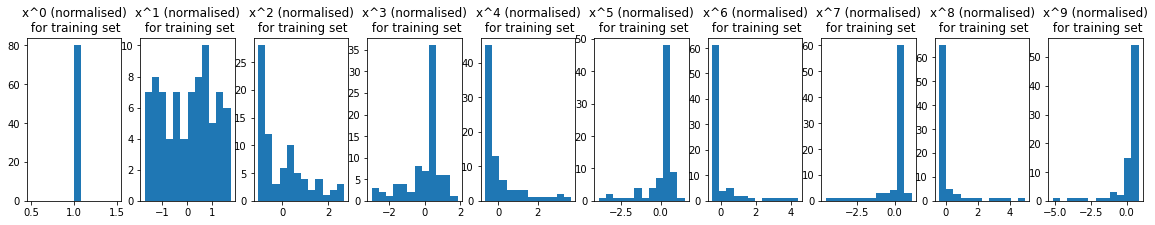

In [12]:
feature_normaliser = FeatureNormaliser()

# Normalizing the training set design matrix

feature_normaliser.fit(X_train[:,1:])
X_train[:,1:] = feature_normaliser.transform(X_train[:,1:])

# Normalizing the testing set design matrix

feature_normaliser.fit(X_test[:,1:])
X_test[:,1:] = feature_normaliser.transform(X_test[:,1:])

# Plotting X_train

fig, ax = plt.subplots(nrows=1, ncols=X_train.shape[1], figsize=(20,3))
for i in range(X_train.shape[1]):
    ax[i].hist(X_train[:,i], bins=12)
    ax[i].set_title(f"x^{i} (normalised)\n for training set")

plt.show()



In [13]:
# Checking the shape to see if they are what we expect
print(f"X shape: {X_train.shape}, y shape: {y_train.shape}")
print("First sample of training data:", X_train[0]) 

print("\n")

print(f"X shape: {X_test.shape}, y shape: {y_test.shape}")
print("First sample of training data:", X_test[0]) # [1, x, x^2, ..., x^k]

X shape: (80, 10), y shape: (80,)
First sample of training data: [ 1.         -1.38351387  1.53847244 -1.57530568  1.43860848 -1.35777836
  1.14617389 -1.03221978  0.84036789 -0.7283996 ]


X shape: (20, 10), y shape: (20,)
First sample of training data: [ 1.         -0.8370895   0.07283512 -0.23929299 -0.29173664  0.1419959
 -0.4341572   0.32066012 -0.466422    0.38644038]


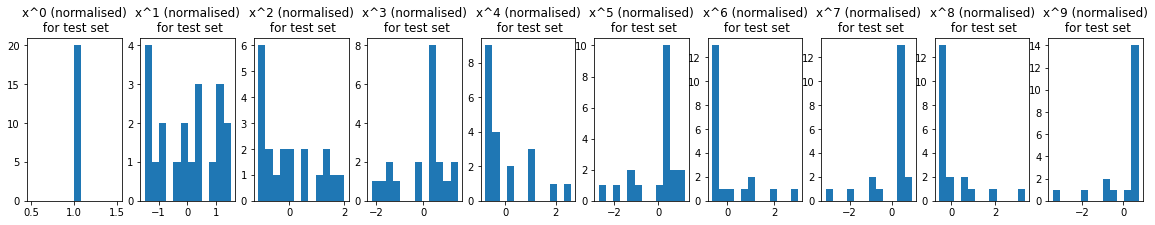

In [14]:
# Plotting X_test

fig, ax = plt.subplots(nrows=1, ncols=X_test.shape[1], figsize=(20,3))
for i in range(X_test.shape[1]):
    ax[i].hist(X_test[:,i], bins=12)
    ax[i].set_title(f"x^{i} (normalised)\n for test set")

plt.show()

#### Closed Form Solution

Now we are going to consider the closed form solution. Give a design matrix X
and labels y

we have the closed form solution
θ=(XTX)−1XTy

where θ
is a (k+1) vector of parameters which correspond to the local minimum of the loss function E(θ)

given by
E(θ)=12(y−Xθ)2.

In [15]:
#Closed form solution
class ClosedFormSol:

  """
  Calculates the closed form solution form a design matrix X and labels y

  """

  def solution(self, X, y):

    self.parameters = np.dot( np.dot( np.linalg.inv( np.dot( X.T, X) ), X.T ),  y )

    return self.parameters

closedformsol = ClosedFormSol()

parameters = closedformsol.solution(X_train, y_train)

Below we have plotted the 9th degree polynomial fit to the data using the parameters found using the closed form solution described above. The mean squared error (MSE) is also calculated.

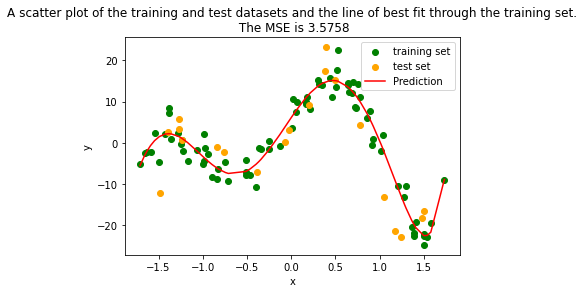

In [16]:
# Plotting the training and test set using scatterplot

plt.scatter(X_train[:,1], y_train, label='training set', color='green')
plt.scatter(X_test[:,1], y_test, label='test set', color='orange')

# Calculate predicted values

y_prediction = np.dot( X_train, parameters.T ).T

# Calculate the MSE

MSE = 1/(2 * y_train.shape[0]) * np.sum( np.square(y_train - y_prediction)) 

# calculate points to plot

# Calculate predicted values

x = X_train[X_train[:, 1].argsort()]
y = np.dot( x, parameters.T ).T

# plot fit

plt.plot( x[:,1], y, label = 'Prediction', color='red')

# Axis labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"A scatter plot of the training and test datasets and the line of best fit through the training set.\n The MSE is {round(MSE,4)}")
plt.legend()
plt.show()

#### Gradient Descent Algorithm

As mentioned above, we are going to use the qubic loss function E(θ)

given by
E(θ)=12∑i=0n(y(i)−f(x(i),θ))2,

where θ
is a (k+1) vector of parameters, y(i) is the label in the ith row, x(i) is the ith input and f(x(i),θ) is the 9th order polynomila that we want to fit to the data which is dependant on the inputs x(i) and parameters θ. The explicit expression for the gradient decent algorithm is given in the lectures and are implimented below

In [17]:
class GradientDecent:
    """
    Preforms gradient decent 
    """

    def deltatheta(self, X, y, int_par):

        # Calculate predictions
        self.fx = np.dot( X, int_par.T ).T

        # Initialise the change in theta
        self.delta = np.zeros(len(int_par))

        # Update each parameter at the same time
        for i in range(len(int_par)):

            self.delta[i] = np.dot( (self.fx - y) , X[:,i] )

        return self.delta


    def iteration(self, int_par, step, learning_rate):

        # One iteration of the decent
        self.par = int_par - learning_rate * step

        return self.par

    def decent(self, X, y, int_par, learning_rate, cutoff):

        # sets initial parameters, step and loss
        self.parameters = int_par
        self.step = 0
        self.loss = []
        self.parlist = [self.parameters]

        # prediction given parameters 
        self.y_prediction = np.dot( X, self.parameters.T ).T

        # initalizing epsilon
        self.epsilon = cutoff + 1

        # while loop until change in parameters are less than close that cutoff
        while self.epsilon > cutoff:

          # calculate step
          self.step = self.deltatheta( X, y, self.parameters)
          # update parameters
          self.parameters = self.iteration(self.parameters, self.step, learning_rate)
          # append to list
          self.parlist.append(self.parameters)

          # calculate loss
          self.loss.append( 1/(2 * y.shape[0]) * np.sum( (y - np.dot( X, self.parameters.T ).T)**2 )  )

          # update epsilon
          self.epsilon = np.sqrt(    np.sum( (self.parlist[-1] - self.parlist[-2])**2 )    )

        return  self.loss, self.parlist, self.parlist[-1]

Now the function GradientDecent().decent(self, X, y, int_par, learning_rate, cutoff) is implemented below. The resulting parameters are compared to the optimal solution calculated using the closed form solution. The learning curve is the plotted to show convergence to a global minimun and this is done for several different learning rates. The best parameters are also quoted below

In [18]:
graddecent = GradientDecent()

# training set
x = X_train
y= y_train

# initial values (chosen to be zero) -- Not a good idea for poly_degree = 9 :)

#theta0 = np.zeros(poly_degree + 1)

# initial values (close to optimal values) for 9th degree poly
 
theta0 = np.array([ -1.16402637,  22.6054855 , -38.99958216, -76.87726199,
        59.95524437,  56.68292995, -58.01778821,  -8.01318888,
        55.48094127,  20.2423465 ])

# implementing gradient decent
loss, all_parmeters, best_fit = graddecent.decent( x, y, theta0, 0.001, 0.00001)

best_fit

array([ -0.16402637,  20.66136344, -37.07385176, -71.34941146,
        57.21040655,  57.03801931, -57.14494392,  -7.45505452,
        55.29570909,  24.61463654])

In [19]:
# Parameters from the closed form solution.
parameters

array([ -0.16402637,  20.6054855 , -36.99958216, -70.87726199,
        56.95524437,  55.68292995, -57.01778821,  -6.01318888,
        55.48094127,  24.2423465 ])

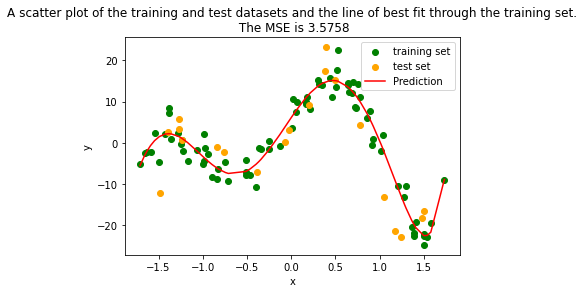

In [20]:
# Plot of the best fit found using gradient decent
# Plotting the training and test set using scatterplot

plt.scatter(X_train[:,1], y_train, label='training set', color='green')
plt.scatter(X_test[:,1], y_test, label='test set', color='orange')

# Calculate predicted values

y_prediction = np.dot( X_train, best_fit.T ).T # predict with gradient decent parameters

# Calculate the MSE

MSE = 1/(2 * y_train.shape[0]) * np.sum( np.square(y_train - y_prediction)) 

# calculate points to plot

# Calculate predicted values

x = X_train[X_train[:, 1].argsort()]
y = np.dot( x, parameters.T ).T

# plot fit

plt.plot( x[:,1], y, label = 'Prediction', color='red')

# Axis labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"A scatter plot of the training and test datasets and the line of best fit through the training set.\n The MSE is {round(MSE,4)}")
plt.legend()
plt.show()

#### The Learning Curve

The learning curve is a plot of the values of loss function as a function of number of iterations, this is use to show canvergence and to help tune the hyperparameters e.g. learning rate. This is done for both the test set and traning set.

First we must calculate the loss on the test set of each iteration


In [21]:
test_loss = []

# loop through all parameters
for par in all_parmeters[1:]:

  # predictions on test set
  y_test_prediction = np.dot( X_test, par.T ).T # predict for each set of par

  # calculate loss for each iteration
  test_loss.append(1/(2 * y_test.shape[0]) * np.sum( np.square(y_test - y_test_prediction)))

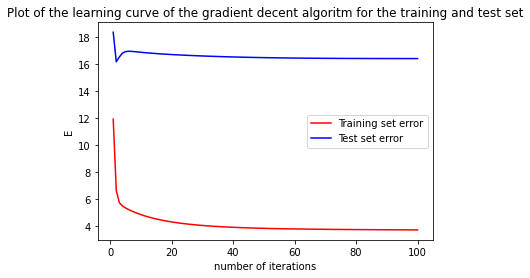

The MSE on the training set: 3.5758
The MSE on the test set: 16.6298


In [22]:
# Calculate loss at each iteration on train and test

num_iteration = np.linspace(1, len(loss) + 1, num=len(loss) )

# Plot learning curve of training set

plt.plot( num_iteration[:100], loss[:100], label = 'Training set error', color='red')

# Plot learning curve of test set

plt.plot( num_iteration[:100], test_loss[:100], label = 'Test set error', color='blue')

# Axis labels and title
plt.xlabel("number of iterations")
plt.ylabel("E")
plt.title("Plot of the learning curve of the gradient decent algoritm for the training and test set")
plt.legend()
plt.show()

# print MSE of test and training set

print(f'The MSE on the training set: {round(loss[-1],4)}' )
print(f'The MSE on the test set: {round(test_loss[-1],4)}' )

### Need regularization

As you can see from the above plot, the learning curve are decreaseing and converge but notice that the test set error is far larger than the training set error. Therefore we have overfit the data, this is what I expected using a 9th degree polynomial which is a high variance model. Lets attempt L2 regularizations.

I will only implement L2 regularization using the close form solution to find the best λ
the this value will be use to plot the loss function as a function of iterations from gradient decent

In [23]:
#Closed form solution with regularization
class ClosedFormSolReg:

    """
    Calculates the closed form solution form a design matrix X and labels y
    and includes regularizations

    """

    def solution(self, X, y, regularization):

        # regularization matrix
        self.dim = X.shape[1]
        self.reg_matrix = regularization * np.identity(self.dim)
        self.reg_matrix[0,0]=0

        # finding parameters with reg
        self.parameters = np.dot( np.dot( np.linalg.inv( np.dot( X.T, X) + self.reg_matrix ), X.T ),  y )

        return self.parameters

closedformsolreg = ClosedFormSolReg()

# find parameters with different regularizations

list_reg = np.linspace(0, 100, num=50)
train_errors =[]
test_errors =[]
par = 0

for r in list_reg:

    # find par for each regularization
    par = closedformsolreg.solution(X_train, y_train, r)

    # predictions on test & training set
    y_train_prediction = np.dot( X_train, par.T ).T
    y_test_prediction = np.dot( X_test, par.T ).T 


    # calculate loss for each regularization
    train_errors.append(1/(2 * y_train.shape[0]) * np.sum( np.square(y_train - y_train_prediction)))
    test_errors.append(1/(2 * y_test.shape[0]) * np.sum( np.square(y_test - y_test_prediction)))

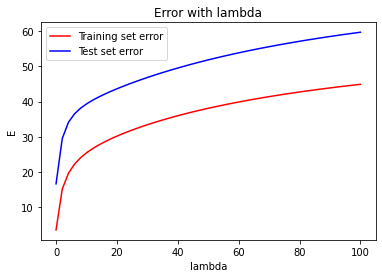

In [24]:
# Plot error of training set with lambda

plt.plot( list_reg, train_errors, label = 'Training set error', color='red')

# Plot learning curve of test set

plt.plot( list_reg, test_errors, label = 'Test set error', color='blue')

# Axis labels and title
plt.xlabel("lambda")
plt.ylabel("E")
plt.title("Error with lambda")
plt.legend()
plt.show()

This is not what is expected, thought there would a global minimum leading to there being an obvious choice for λ, however this does not seem to be the case and the case of λ=0 is the optimal regularizations. In this case it would not be useful to do this for gradient decent.